In [1]:
from IPython.display import Image
%matplotlib inline

In [2]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

##### 腫瘍データ

In [3]:
import pandas as pd
import urllib

try:
    df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
                     '/breast-cancer-wisconsin/wdbc.data', header=None)

except urllib.error.URLError:
    df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                     'python-machine-learning-book/master/code/'
                     'datasets/wdbc/wdbc.data', header=None)
    
print('rows, columns:', df.shape)
df.head()

rows, columns: (569, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:

df.shape

(569, 32)

M(悪性) →　1  , B(良性) →　0

In [5]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

##### データをトレーニングデータとテストデータに分割

In [6]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)

##### パイプライン結合

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])

pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))
y_pred = pipe_lr.predict(X_test)

Test Accuracy: 0.947


##### K点交差検証

In [8]:
import numpy as np

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import StratifiedKFold
else:
    from sklearn.model_selection import StratifiedKFold
    

if Version(sklearn_version) < '0.18':
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=10,
                            random_state=1)
else:
    kfold = StratifiedKFold(n_splits=10,
                            random_state=1).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.029


##### k点交差検証関数

In [9]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import cross_val_score
else:
    from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


##### 学習曲線

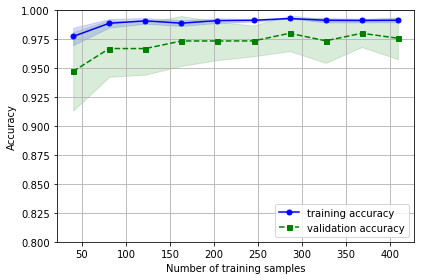

In [10]:
import matplotlib.pyplot as plt

if Version(sklearn_version) < '0.18':
    from sklearn.learning_curve import learning_curve
else:
    from sklearn.model_selection import learning_curve



pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

#### トレーニングデータとテストデータとの隔たりがあるために、過学習が見て取れる。

#### 検証曲線を利用して、過学習と学習不足を明らかにする

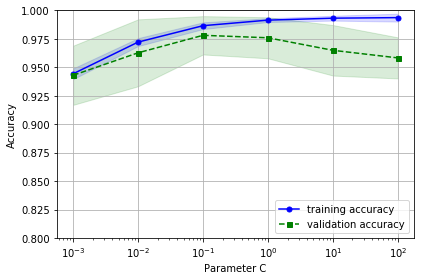

In [11]:
if Version(sklearn_version) < '0.18':
    from sklearn.learning_curve import validation_curve
else:
    from sklearn.model_selection import validation_curve



param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()

#### パラメータCを変化させたときの正解率を検証曲線とし、ここでは　C=0.1 が最適だとわかる

### グリッドサーチを利用して網羅的なパラメーターチューニングを行う

In [12]:
from sklearn.svm import SVC
if Version(sklearn_version) < '0.18':
    from sklearn.grid_search import GridSearchCV
else:
    from sklearn.model_selection import GridSearchCV

pipe_svc = Pipeline([('scl', StandardScaler()),
            ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'clf__C': param_range, 
               'clf__kernel': ['linear']},
                 {'clf__C': param_range, 
                  'clf__gamma': param_range, 
                  'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978022
{'clf__C': 0.1, 'clf__kernel': 'linear'}


#### トレーニングデータセットとは独立したテストデータを使用してモデル評価

In [13]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


### 入れ子式の交差検証によるアルゴリズム選択

#### SVMモデルの評価

In [14]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

# Note: Optionally, you could use cv=2 
# in the GridSearchCV above to produce
# the 5 x 2 nested CV that is shown in the figure.

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


#### 決定木モデルの評価

In [15]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.921 +/- 0.029


### 正解率　SVMモデル:96.5% ＞決定木モデル：92.1% 　

<p>

## 混同行列について

![](06_08.png)

In [26]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


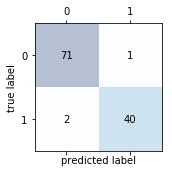

In [17]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

## 混合行列の結果を利用して、分類モデルの適合率と再現率を最適化

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


適合率：97.6　<p>
再現率：95.2<p>
F1スコア：96.4 (適合率と再現率が含まれている)<p>

In [19]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'clf__C': c_gamma_range,
               'clf__kernel': ['linear']},
              {'clf__C': c_gamma_range,
               'clf__gamma': c_gamma_range,
               'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.982798668208
{'clf__C': 0.1, 'clf__kernel': 'linear'}


## ROC曲線をプロット

性能に基づいて分類モデルを選択するためのツール<p>
ROC曲線の対角線を下回る分類モデルは劣るとみなされる<p>
完璧な分類器はグラフの左上隅に位置づけられる<p>
分類モデルの性能を明らかにするために、ROC曲線に基づいて、曲線下面積を計算

腫瘍データの特徴量を2つだけを使用し、良性か悪性かを予測するROC曲線をプロット

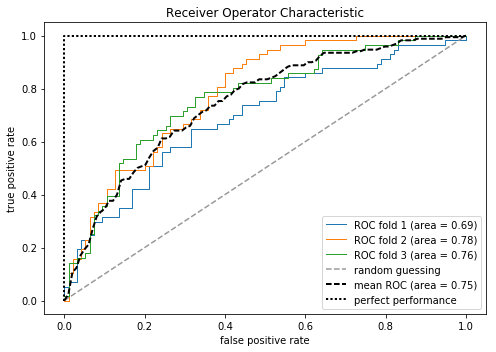

In [20]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])

X_train2 = X_train[:, [4, 14]]


if Version(sklearn_version) < '0.18':
    cv = StratifiedKFold(y_train, 
                         n_folds=3, 
                         random_state=1)
    
else:
    cv = list(StratifiedKFold(n_splits=3, 
                              random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

In [21]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_labels = pipe_lr.predict(X_test[:, [4, 14]])
y_probas = pipe_lr.predict_proba(X_test[:, [4, 14]])[:, 1]
# note that we use probabilities for roc_auc
# the `[:, 1]` selects the positive class label only

In [22]:
from sklearn.metrics import roc_auc_score, accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_probas))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_labels))

ROC AUC: 0.752
Accuracy: 0.711


曲線下面積AUC:75.2%